In [2]:
fn = 'yellow_tripdata_2019-01'
filepath = '../../../Downloads/csv'

pickup_time_col_name = 'tpep_pickup_datetime'
drop_time_col_name = 'tpep_dropoff_datetime'

import pandas as pd
import numpy as np
from datetime import datetime
import math
import time
import matplotlib as mpl
import matplotlib.pyplot as plt

import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
from IPython import display
plt.style.use('ggplot')
%matplotlib inline

from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType
from pyspark.sql.types import DoubleType
# from pyspark.sql import Row

spark = SparkSession \
    .builder \
    .appName("Read CSVs") \
    .getOrCreate()
    


# Section 1: ETL for the Simulation

In [3]:
df = spark.read.format('csv').options(header='true', inferSchema='true').load(filepath + '/' + fn + '.csv')

df.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|       1| 2019-01-01 00:46:40|  2019-01-01 00:53:20|              1|          1.5|         1|                 N|         151|         239|           1|        7.0|  0.5|    0.5|      1.65|         0.0|                  0.3

In [4]:
## Extra Columns appending   
weekDay =  F.udf(lambda x: x.weekday()) # 0: Monday
hourDay = F.udf(lambda x: x.hour)
minuteDay = F.udf(lambda x: (x.hour*60 + x.minute)//10*10)
dayDay = F.udf(lambda x: x.day)
monthYear = F.udf(lambda x: x.month)
yearYear = F.udf(lambda x: x.year)
minuteTrip = F.udf(lambda x, y: (y - x).total_seconds()/60)

df = df.withColumn('pickup_year', yearYear(F.col(pickup_time_col_name)).cast(IntegerType()))
df = df.withColumn('pickup_month', monthYear(F.col(pickup_time_col_name)).cast(IntegerType()))
df = df.withColumn('pickup_day', dayDay(F.col(pickup_time_col_name)).cast(IntegerType()))
df = df.withColumn('pickup_hour', hourDay(F.col(pickup_time_col_name)).cast(IntegerType()))
df = df.withColumn('pickup_weekday', weekDay(F.col(pickup_time_col_name)).cast(IntegerType()))
df = df.withColumn('pickup_minutes', minuteDay(F.col(pickup_time_col_name)).cast(IntegerType()))
df = df.withColumn('travel_time', minuteTrip(F.col(pickup_time_col_name), F.col(drop_time_col_name)).cast(DoubleType()))
df = df.withColumn('travel_speed', (F.col('trip_distance')/minuteTrip(F.col(pickup_time_col_name), F.col(drop_time_col_name))*60).cast(DoubleType()))


## Data cleaning
clean_col = 'trip_distance'
df1 = df.filter((F.col(clean_col) > 0.1) & (F.col(clean_col) < 264))

clean_col = 'total_amount'
df2 = df1.filter((F.col(clean_col) > 0.1) & (F.col(clean_col) < 1000))

clean_col = 'passenger_count'
df3 = df2.filter((F.col(clean_col) >= 0) & (F.col(clean_col) < 7))

## DROP NA: from 2019, unnecessary, data stay good quality
# df4 = df3.dropna()

## Prepare data for real-time simulation display of GUI on 10-min based data set 

Here, as the column of 'pickup_minute', which is the reult of match round calculation down to the latest 10 minutes. The function used above is `(lambda x: (x.hour*60 + x.minute)//10*10)`, i.e. 16:35 is treated as 16*60+30 = 990. So we get a column which is categoried as 10-minutes based. The following charts showed this.



In [5]:
df_sim = df3.select('pickup_minutes', 'PULocationID')
df_sim.show()

+--------------+------------+
|pickup_minutes|PULocationID|
+--------------+------------+
|            40|         151|
|            50|         239|
|            20|         163|
|            30|         229|
|            50|         141|
|            20|         246|
|            20|         238|
|            40|         163|
|            40|         224|
|            50|         141|
|            20|         170|
|            30|         170|
|            40|         107|
|            50|         170|
|            10|          41|
|            40|         113|
|            50|         161|
|            10|         138|
|            10|         144|
|            20|         231|
+--------------+------------+
only showing top 20 rows



In [6]:
df_sim_grouped = df_sim\
    .groupby('pickup_minutes', 'PULocationID')\
    .agg(F.count('pickup_minutes').alias('10mins_COUNT'))\
    .orderBy('pickup_minutes', ascending=True)

# df_sim_grouped.show()

### Export data set needed to csv file.

Aggregation on Spark dataframe is very slow, evern show() is hard if the data is millions of rows. Therefore, when we got the needed mimimum data set, let's save it to a csv file for usage afterwards.

In [7]:
pdf = df_sim_grouped.toPandas()

In [8]:
pdf.to_csv('dataframe_for_simu.csv')

In [9]:
pdf.head()

pickup_minutes  PULocationID  10mins_COUNT
0               0           190             1
1               0           162           966
2               0            25            44
3               0            65            52
4               0           149             1

# Section 2: Simulation Matplotlib Version(Manual)
Clean (restart python kernel) and reload the exported csv files


In [1]:
fn = 'dataframe_for_simu'
filepath = './'

pickup_time_col_name = 'tpep_pickup_datetime'
drop_time_col_name = 'tpep_dropoff_datetime'

import pandas as pd
import numpy as np
from datetime import datetime
import math
import time
import matplotlib as mpl
import matplotlib.pyplot as plt

import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
from IPython import display
plt.style.use('ggplot')
%matplotlib inline

from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType
from pyspark.sql.types import DoubleType
# from pyspark.sql import Row

spark = SparkSession \
    .builder \
    .appName("Read CSVs") \
    .getOrCreate()
    

df = spark.read.format('csv').options(header='true', inferSchema='true').load(filepath + '/' + fn + '.csv')

df.show()

+---+--------------+------------+------------+
|_c0|pickup_minutes|PULocationID|10mins_COUNT|
+---+--------------+------------+------------+
|  0|             0|         190|           1|
|  1|             0|         162|         966|
|  2|             0|          25|          44|
|  3|             0|          65|          52|
|  4|             0|         149|           1|
|  5|             0|         244|          55|
|  6|             0|         152|          32|
|  7|             0|         145|          50|
|  8|             0|         243|           4|
|  9|             0|         160|           1|
| 10|             0|         212|           2|
| 11|             0|          13|         175|
| 12|             0|         107|        1045|
| 13|             0|         186|        1152|
| 14|             0|         158|         638|
| 15|             0|         261|         159|
| 16|             0|          88|         121|
| 17|             0|          48|        1877|
| 18|        

## Load the shapefiles

In [2]:
# %% Load the shapefiles

def get_lat_lon(sf):
    content = []
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        
        content.append((loc_id, x, y))
    return pd.DataFrame(content, columns=["LocationID", "longitude", "latitude"])



sf = shapefile.Reader("shape/taxi_zones.shp")
fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

# just for display the data
df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf).set_index("LocationID"), on="LocationID")
df_loc.head()

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough     longitude       latitude  
0            EWR  9.366817e+05  190522.130278  
1         Queens  1.033536e+06  161853.982300  
2          Bronx  1.027136e+06  254730.010849  
3      Manhattan  9.904240e+05  203100.040432  
4  Staten Island  9.321332e+05  139954.541936

The above longitude and latitude is likely New York State Plane (NYSP) zone but seems those are defined with feet and the other with meters. No good tools found so far to cope with standard longtitude/latitude or UTM format.

So, the following ploting method is straightforward by using matlotlib to make the updated plotting for simulation.

## Data set as input for simulator function

From the table showed above, the **pickup_minutes** is from 0 to 1430, as the 10minutes interval based, and there are 1440 minutes per day. Therefore there is 144 groups in which there are the sum of yellow taxi pickups for every location id(PULocationID).

Therefore, the real-time plotting will have 144 frames and in each frame the numbers (so far no colormap to indicate the numbers yet).

In [3]:
df.show()

+---+--------------+------------+------------+
|_c0|pickup_minutes|PULocationID|10mins_COUNT|
+---+--------------+------------+------------+
|  0|             0|         190|           1|
|  1|             0|         162|         966|
|  2|             0|          25|          44|
|  3|             0|          65|          52|
|  4|             0|         149|           1|
|  5|             0|         244|          55|
|  6|             0|         152|          32|
|  7|             0|         145|          50|
|  8|             0|         243|           4|
|  9|             0|         160|           1|
| 10|             0|         212|           2|
| 11|             0|          13|         175|
| 12|             0|         107|        1045|
| 13|             0|         186|        1152|
| 14|             0|         158|         638|
| 15|             0|         261|         159|
| 16|             0|          88|         121|
| 17|             0|          48|        1877|
| 18|        

In [4]:
# for every 10 mins, there are two inputs for simulation function: loctexts and counts.

mins10s = []
loctexts = []
counts = []


for i in range(0, 144):
    cur_10mins = i*10
    mins10s.append(cur_10mins)
    dfi = df.filter(F.col('pickup_minutes') == cur_10mins)

    loctextsi = list(dfi.select('PULocationID').toPandas()['PULocationID'])
    countsi = list(dfi.select('10mins_COUNT').toPandas()['10mins_COUNT'])
    loctexts.append(loctextsi)
    counts.append(countsi)


## Functions to do the live plotting


In [5]:
# functions for plotting

# called func
def get_boundaries(sf):
    lat, lon = [], []
    for shape in list(sf.iterShapes()):
        lat.extend([shape.bbox[0], shape.bbox[2]])
        lon.extend([shape.bbox[1], shape.bbox[3]])

    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    return lat_min, lat_max, lon_min, lon_max

def draw_zone_map(ax, sf, curmin=[], loctext=[], loccount=[], threshold=0):
    # for update plotting
    display.clear_output(wait=True)
    plt.cla()
    
    ax.set_title("Zones in NYC @" + str(math.floor((curmin)/60)) + ":" + str(curmin - math.floor((curmin)/60)*60))

                 
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)
    theta = np.linspace(0, 2*np.pi, len(loctext)+1).tolist()
    ax.set_facecolor(ocean)
    

    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        zone = rec[shp_dic['zone']]
        
        col = continent
        # if len(heat) == 0:
            # col = continent
        # else:
        #     if loc_id not in heat:
        #         R,G,B,A = cm(norm(0))
        #     else:
        #         R,G,B,A = cm(norm(heat[loc_id]))
        #     col = [R,G,B]

        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        

        # shrink the input list for display on plot
        text = []
        count = []
        for i in range(0, len(loccount)):
            if loccount[i] > threshold:
                count.append(loccount[i])
                text.append(loctext[i])

        # plt.text(x, y, str(loc_id), horizontalalignment='center', verticalalignment='center')            
        
        if (len(text) == 0 and rec[shp_dic['Shape_Area']] > 0.0001):
            plt.text(x, y, str(loc_id), horizontalalignment='center', verticalalignment='center')            
        elif len(text) != 0 and loc_id in text:
            # #plt.text(x+0.01, y-0.01, str(loc_id), fontsize=12, color="white", bbox=dict(facecolor='black', alpha=0.5))
            eta_x = 0.05*np.cos(theta[text.index(loc_id)])
            eta_y = 0.05*np.sin(theta[text.index(loc_id)])
            # pass

            loc_count = count[text.index(loc_id)]

            if threshold == 0 and len(text) < 50:
                ax.annotate("[{}] {}".format(loc_count, zone), xy=(x, y), xytext=(x+eta_x, y+eta_y),
                            bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=10,
                            arrowprops=dict(facecolor='black', width=3, shrink=0.05))
            else:
                ax.annotate("{}".format(loc_count), xy=(x, y), xytext=(x+eta_x, y+eta_y),
                            bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=10,
                            arrowprops=dict(facecolor='black', width=3, shrink=0.05))


    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])
    
    # for update plotting
    display.display(plt.gcf())



### Input arguments for draw_zone_map()
curmin is array of current time, minutes math.floor to latest 10 minutes.

loctext is array of id as text to show for each location.

loccount is arry of count for location.

threshold is an integer, compared with the pickup count of the locations, only location will be plotted if its count higher than the threshold. This is the value to control how much points will be shown on map.

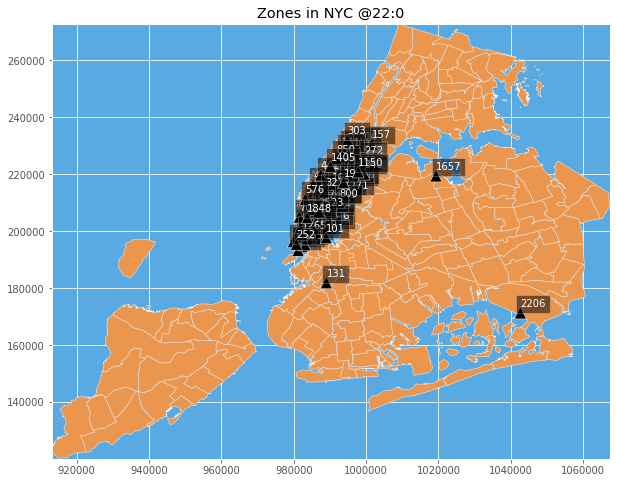

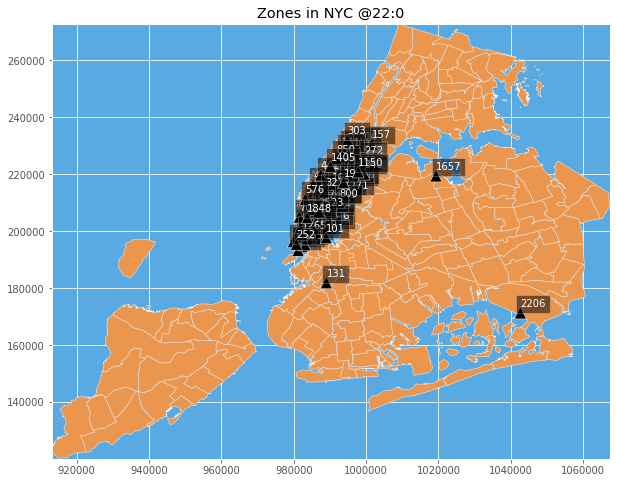

In [16]:
# %% plot shapefile
fig, ax = plt.subplots(1, figsize=(10, 8))

# range(0,144) # 10 minutes based, so it's 0 - 1440 minutes (there are 1440 minutes per day).
for ii in range(108, 133):

    draw_zone_map(ax, sf, curmin=mins10s[ii], loctext=loctexts[ii], loccount=counts[ii], threshold=100)  
    ## counts: monthly average:

# Section 3: Simulation GeoPands Version


In [10]:
fn = 'dataframe_for_simu'
filepath = './'


import geopandas

from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType
from pyspark.sql.types import DoubleType

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from IPython import display

import time


spark = SparkSession \
    .builder \
    .appName("Read CSVs") \
    .getOrCreate()


gdf = geopandas.read_file("shape/taxi_zones.shp")

# gdf = geopandas.read_file(geopandas.datasets.get_path('nybb'))
# ax = gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

df = spark.read.format('csv').options(header='true', inferSchema='true').load(filepath + '/' + fn + '.csv')

In [11]:
## Get the get_boundaries
geoseries = gdf['geometry']
lims = geoseries.bounds
xmin, ymin = lims.min()[[0, 1]]
xmax, ymax = lims.max()[[2, 3]]

print(xmin, xmax, ymin, ymax)

913175.109008804 1067382.508405164 120121.88125434518 272844.2940054685


In [12]:
## for specific 10mins bin, join gdf(Geopanda DataFrame) with selected df on LocationID
left = gdf
right = df.toPandas()
right.rename(columns={'PULocationID': 'LocationID'},inplace=True)

gdf_alldaylong = left.merge(right, on='LocationID')

In [13]:
## Generate 144 bins to hold data for every plot
gdf144 = []
for ii in range(0, 144):
    gdf_10 = gdf_alldaylong[gdf_alldaylong['pickup_minutes']==ii*10]
    gdf144.append(gdf_10)



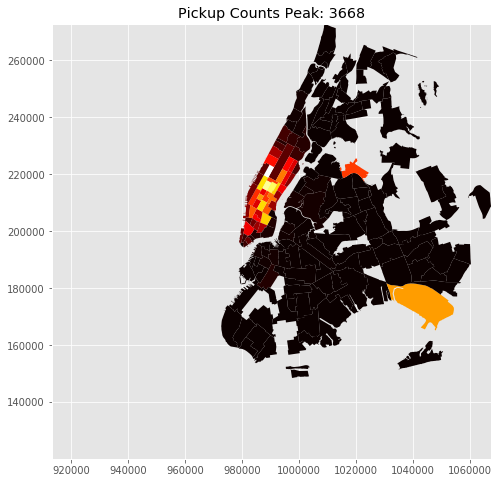

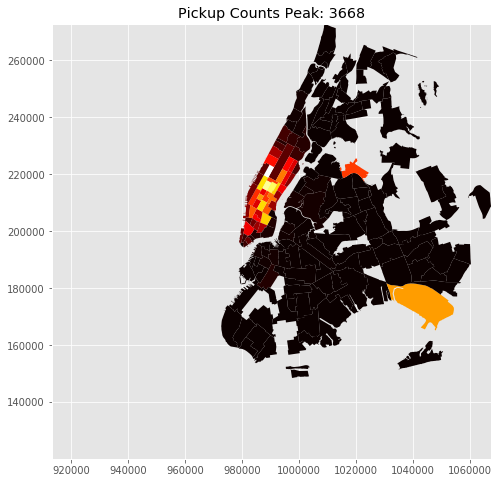

In [15]:
## Simulation for live plotting
threshold_count = 0
hour_plot = 18
frame_number = 25


fig, ax = plt.subplots(1, figsize=(10, 8))
for jj in range(hour_plot*6, hour_plot*6 + frame_number):
    # for live plotting 1/2
    display.clear_output(wait=True)
    plt.cla()
    
    # fix the xlim and ylim
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

    # retrieve and filter data for the current 10mins
    gdf_10 = gdf144[jj]
    gdf_to_plot = gdf_10[gdf_10['10mins_COUNT']>=threshold_count]
    
    # label the X title by using the maximum of pickup counts, while not using legend (extra axes)
    ax.set_title("Pickup Counts Peak: " + str(gdf_10['10mins_COUNT'].max()))

    # geopandas plot
    gdf_to_plot.plot(column='10mins_COUNT', ax = ax, figsize=(5, 5), cmap='hot')

    # for live plotting 2/2
    display.display(plt.gcf())
    time.sleep(1)

    